## Introduction
This notebook is for clean the dataset downloaded from Lending Club website.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import time
from scipy.stats import shapiro
import statsmodels.api as sm
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## PreProcessing

The dataset was download from [Lending Club](https://www.lendingclub.com/statistics/additional-statistics?). It contains information from 2015 to 2019. 

**Data manipulation**: 

    - Deal with missing value 
    - check each feature
        - observe distribution (normality for particular features)
        - Remove outliner (standard deviation)



In [2]:
# read data
start = time.time()
path = '/Users/cyuancheng/Documents/course/Springboard/Capstone1/data/'
df = pd.read_csv(path+'data_col_pickup.csv', low_memory=True, index_col=0, \
                 parse_dates=['issue_d', 'earliest_cr_line', 'last_pymnt_d'] )
end = time.time()
print('It takes  ' + str(end-start) +' sec to read the data')

It takes  31.012874841690063 sec to read the data


In [3]:
df.head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d,int_rate,revol_util,term,grade,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,loan_amnt,funded_amnt,installment,annual_inc,int_rate.1,dti,revol_bal,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,total_pymnt,recoveries
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10224583,2013-12-01,2001-06-01,2016-02-01,2018-06-01,14.98,66.2,36 months,C,10+ years,MORTGAGE,Not Verified,Fully Paid,other,NY,11100.0,11100.0,384.68,90000.0,14.98,3.73,6619.0,1.0,9.0,0.0,694.0,690.0,13575.640006,0.0
10148122,2013-12-01,2003-09-01,2016-06-01,2020-01-01,7.62,55.7,36 months,A,3 years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,TX,12000.0,12000.0,373.94,96500.0,7.62,12.61,13248.0,0.0,17.0,0.0,709.0,705.0,13397.539998,0.0
10149342,2013-12-01,1986-10-01,2016-07-01,2018-03-01,10.99,61.2,36 months,B,10+ years,OWN,Verified,Fully Paid,debt_consolidation,MI,27050.0,27050.0,885.46,55000.0,10.99,22.87,36638.0,0.0,14.0,0.0,734.0,730.0,31752.530000,0.0
10129454,2013-12-01,2009-12-01,2016-04-01,2018-08-01,10.99,24.0,36 months,B,4 years,RENT,Not Verified,Fully Paid,debt_consolidation,NC,12000.0,12000.0,392.81,60000.0,10.99,4.62,7137.0,0.0,15.0,0.0,724.0,720.0,13988.609996,0.0
10149488,2013-12-01,1995-08-01,2014-09-01,2017-01-01,10.99,16.1,36 months,B,2 years,MORTGAGE,Source Verified,Fully Paid,home_improvement,TX,4800.0,4800.0,157.13,39600.0,10.99,2.49,4136.0,0.0,3.0,0.0,759.0,755.0,5157.519457,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2730228 entries, 10224583 to 158206429
Data columns (total 28 columns):
issue_d                datetime64[ns]
earliest_cr_line       datetime64[ns]
last_pymnt_d           datetime64[ns]
last_credit_pull_d     object
int_rate               float64
revol_util             float64
term                   object
grade                  object
emp_length             object
home_ownership         object
verification_status    object
loan_status            object
purpose                object
addr_state             object
loan_amnt              float64
funded_amnt            float64
installment            float64
annual_inc             float64
int_rate.1             float64
dti                    float64
revol_bal              float64
delinq_2yrs            float64
open_acc               float64
pub_rec                float64
fico_range_high        float64
fico_range_low         float64
total_pymnt            float64
recoveries             float6

In [5]:
# check columns
print(sorted(df.columns))

['addr_state', 'annual_inc', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'installment', 'int_rate', 'int_rate.1', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'open_acc', 'pub_rec', 'purpose', 'recoveries', 'revol_bal', 'revol_util', 'term', 'total_pymnt', 'verification_status']


In [6]:
df.drop(['int_rate.1'], axis=1, inplace=True)

In [7]:
print("Dataset has " + str(df.shape[0]) + " rows" +' and ' + str(df.shape[1]) + ' columns')

Dataset has 2730228 rows and 27 columns


## Pre-processing 

- Set loan status as target


### Target

In [8]:
df['loan_status'].value_counts(dropna=False)

Fully Paid            1346628
Current               1017832
Charged Off            327698
Late (31-120 days)      22638
In Grace Period         10754
Late (16-30 days)        4619
Default                    48
Issued                     11
Name: loan_status, dtype: int64

In [9]:
# only select either 'Fully Paid' or 'Charged Off' for Target
df = df.loc[df['loan_status'].isin(["Fully Paid", "Charged Off"])]

In [10]:
# check missing value
df['loan_status'].isnull().sum()

0

In [11]:
# check distribution for binary classification
df['loan_status'].value_counts(normalize=True)

Fully Paid     0.804281
Charged Off    0.195719
Name: loan_status, dtype: float64

It looks like the target is imbalance

Next, tag the 'Fully Paid' to 0; 'Charged Off' to 1

In [12]:
# fully paid: 0, charged off:1
df['target'] = df['loan_status'].apply(lambda x:0 if x=='Fully Paid' else 1)
df['target'].value_counts(normalize=True) 

0    0.804281
1    0.195719
Name: target, dtype: float64

### Calculate loan period
calcluate the time period of the loan for each borrower
- `last payment date` minus `loan issue date`

In [13]:
df['loan_period'] = (df['last_pymnt_d'] - df['issue_d']) / np.timedelta64(1, 'M')

In [14]:
# remove loan_period = 0
df = df[df['loan_period']!=0]

(0, 0.1)

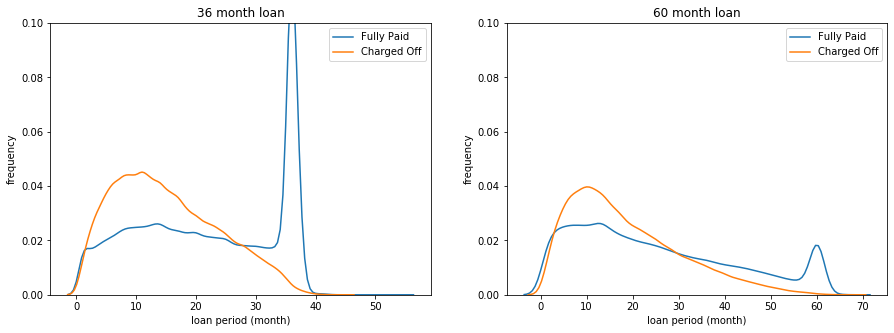

In [16]:
# compare loan period for 36 month vs 60 month loan
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,5))

sns.distplot(df[(df['target']==0) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50, rug=False, label = 'Fully Paid', ax=ax1)
sns.distplot(df[(df['target']==1) & (df['term']== ' 36 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Charged Off', ax=ax1)

ax1.set_title('36 month loan')
ax1.set_xlabel('loan period (month)')
ax1.set_ylabel('frequency')
ax1.set_ylim([0, 0.1])

sns.distplot(df[(df['target']==0) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Fully Paid', ax=ax2)
sns.distplot(df[(df['target']==1) & (df['term']== ' 60 months')]['loan_period'], hist=False, \
             bins=50,rug=False, label = 'Charged Off', ax=ax2)

ax2.set_title('60 month loan')
ax2.set_xlabel('loan period (month)')
ax2.set_ylabel('frequency')
ax2.set_ylim([0, 0.1])

For borrowers who have 36 month loan, they tend to pay off at the very end of their loans.

### List description for each column

In [17]:
df_description = pd.read_excel('LCDataDictionary.xlsx').dropna()
df_description_pick = df_description[df_description['LoanStatNew'].isin(df.columns)]
df_description_pick.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
2,addr_state,The state provided by the borrower in the loan application
4,annual_inc,The self-reported annual income provided by the borrower during registration.
13,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
16,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
18,earliest_cr_line,The month the borrower's earliest reported credit line was opened
19,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
21,fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
22,fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
23,funded_amnt,The total amount committed to that loan at that point in time.
25,grade,LC assigned loan grade


### Deal with term

In [24]:
df['term_num'] = df['term'].str.extract('(\d+)',expand=False).astype(int)
df['term_num'].head(2)

id
10224583    36
10148122    36
Name: term_num, dtype: int64

### Calculate investment return


Next, we calculate the annual loan investiment return $r$ based on the following assumption:
$$
r = \frac{p_1-p_0}{p_0}\times \frac{12}{t}
$$

$p_1$ is the total amount of loan received (total payment)

$p_0$ is the total amount committed to that loan at that point in time (funded amount)
    
$t$ is the loan period in month (loan period) - the actual number of months from the date of loan was issued to the date the last payment was made.

* this simple model does not consider reinvestiment.

In [294]:
df['return_1'] = ( (df['total_pymnt'] - df['funded_amnt'] )
                                            / df['funded_amnt'] ) * (12 / df['loan_period'])

df['return_2'] = ( (df['total_pymnt'] - df['funded_amnt'] )
                                            / df['funded_amnt'] ) * (12 / df['term_num'])

df['return_3'] = df['return_1'].copy()

Assumption: return_3
If a loan has a positive return, we use return_1 
If the loan has a loss, we use return_2

In [295]:
df.loc[df['return_3']<0, 'return_3']= df[df['return_1']<0]['return_2']

(-1, 1)

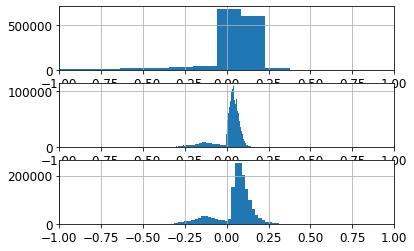

In [296]:
plt.subplot(3,1,1)
df['return_1'].hist(bins=100)
plt.xlim([-1,1])
plt.subplot(3,1,2)
df['return_2'].hist(bins=100)
plt.xlim([-1,1])
plt.subplot(3,1,3)
df['return_3'].hist(bins=100)
plt.xlim([-1,1])

In [79]:
# show missing data
df.isnull().sum()[df.isnull().sum() >0]/len(df)*100

emp_length    6.267652
dti           0.050963
dtype: float64

In [80]:
#Drop the row where at least one element is missing.
df.dropna(axis=0, inplace=True)

In [81]:
# show missing data
df.isnull().sum()[df.isnull().sum() >0]/len(df)*100

Series([], dtype: float64)

In [82]:
df_ml = df.copy()

In [83]:
df_ml.shape

(1557756, 33)

### Remove Outlier
- Remove outliers from numerical columns
- Because most of the numerical feature is not a normal distribution, we can use IQR to remove the outlier

In [84]:
col_num = df.select_dtypes(include=np.number).columns.tolist()
col_num.remove('target')
col_num.remove('loan_period')

In [85]:
# pick up column to remove outliner
col_num

['int_rate',
 'revol_util',
 'loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'total_pymnt',
 'recoveries',
 'term_num',
 'return_1',
 'return_2',
 'return_3']

In [86]:
def remove_outlier_IQR(df, col_name):
    '''
    remove outliner (above/below 1.5*IQR)
    input: original dataframe, column name
    output: new dataframe (without outliner)
    '''
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return df[~((df[col_name] > upper_bound) | (df[col_name] < lower_bound))]#.any(axis=1)]

### Look at indifivual feature

Examine each feature individually, and do the following:

- View summary statistics and visualize the data against the loan status.
- Modify the feature to make it useful for modeling.
- Drop the feature, if it is not useful to predict the loan status.

In [205]:
# make general plots to examine each feature
def plot_num(df, col_name, full_name, width, height):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    # seperate dataframe: 'fully paid' vs 'charged off'
    df_fp = df.loc[df['loan_status'] == 'Fully Paid']
    df_co = df.loc[df['loan_status'] == 'Charged Off']
    
    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(width,height))
    # plot1: counts distribution of the variable
    sns.distplot(df_fp[col_name], hist=False, rug=False, label = 'Fully Paid', ax=ax1)
    sns.distplot(df_co[col_name], hist=False, rug=False, label = 'Charged Off', ax=ax1)
    
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    #plt.show()
          
    # plot2: box plot of the variable grouped by loan_status
    sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
    ax2.set_xlabel(full_name)
    ax2.set_ylabel('')
    ax2.set_title(full_name)
  
    plt.tight_layout()

In [115]:
def plot_cat(df, col_name, full_name, height=5):
    """
    Visualize a numerical variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """

    plt.rcParams.update({'font.size': 12})
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,height))
    # plot1: counts distribution of the variable

    sns.countplot(y=col_name, data = df, order = df[col_name].value_counts().index, \
                  color = 'steelblue', ax=ax1)
    ax1.set_xlabel('Count')
    ax1.set_ylabel('')
    ax1.set_title(full_name)

    #plt.show()
          
    # plot2: box plot of the variable grouped by loan_status
    charged_off_rate = df.groupby(col_name)['loan_status']\
    .value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

    sns.barplot(x=charged_off_rate.values, y=charged_off_rate.index, orient = "h", \
                order=charged_off_rate.index, color = 'steelblue',ax=ax2)

    ax2.set_xlabel('Charged off rate')
    ax2.set_ylabel('')
    ax2.set_title(full_name)

    plt.tight_layout()

In [88]:
# function to check normality
# Shapiro-Wilk Test

def Shapiro_Wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

#### datetime type

**`issue_d`**
- The month which the loan was funded


In [89]:
df['issue_d'].describe()

count                 1557756
unique                     96
top       2016-03-01 00:00:00
freq                    52373
first     2012-01-01 00:00:00
last      2019-12-01 00:00:00
Name: issue_d, dtype: object

**`earliest_cr_line`**
- The month the borrower's earliest reported credit line was opened

In [90]:
df['earliest_cr_line'].describe()

count                 1557756
unique                    742
top       2003-09-01 00:00:00
freq                    10883
first     1933-03-01 00:00:00
last      2016-10-01 00:00:00
Name: earliest_cr_line, dtype: object

**`last_pymnt_d`**
- Last month payment was received

In [91]:
df['last_pymnt_d'].describe()

count                 1557756
unique                     97
top       2019-07-01 00:00:00
freq                    38205
first     2012-02-01 00:00:00
last      2020-02-01 00:00:00
Name: last_pymnt_d, dtype: object

#### Numerical variable

For numerical variable, check normality using 

**`int_rate`**
- Interest Rate on the loan

In [92]:
df['int_rate'].describe()

count    1.557756e+06
mean     1.319864e+01
std      4.821686e+00
min      5.310000e+00
25%      9.670000e+00
50%      1.269000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

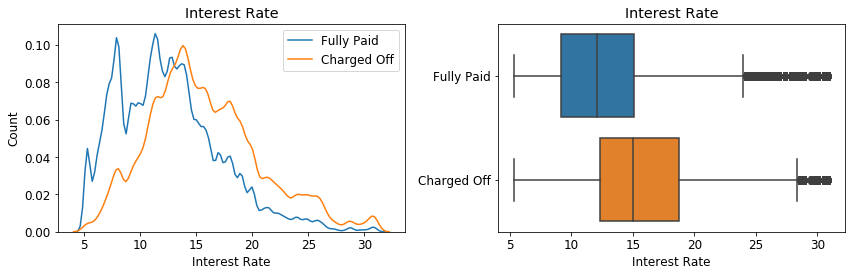

In [209]:
plot_num(df, 'int_rate', 'Interest Rate', 12,4)

after removing outlier:

In [94]:
df_int_rate = df[['int_rate', 'loan_status']].copy()

In [95]:
len(df['int_rate'])

1557756

In [96]:
df_int_rate = remove_outlier_IQR(df_int_rate, 'int_rate')

In [97]:
len(df_int_rate)

1527017

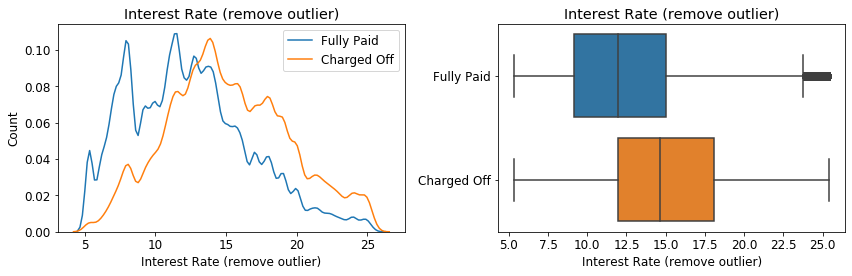

In [210]:
plot_num(df_int_rate, 'int_rate', 'Interest Rate (remove outlier)', 12,4)

The borrowers who are charged off tend to have higher interest rate

**`revol_util`**
- Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

In [99]:
df['revol_util'].describe()

count    1.557756e+06
mean     5.124032e+01
std      2.454672e+01
min      0.000000e+00
25%      3.270000e+01
50%      5.140000e+01
75%      7.010000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

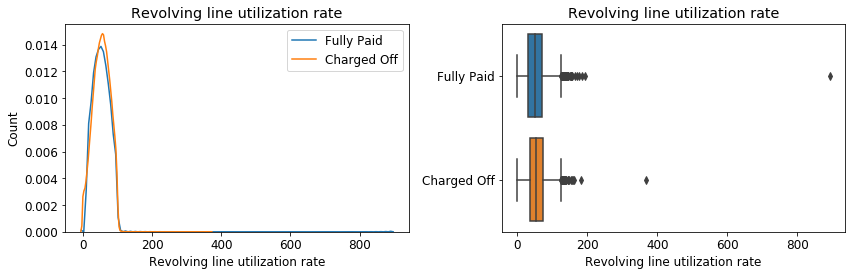

In [211]:
plot_num(df, 'revol_util', 'Revolving line utilization rate', 12,4)

remove outlier

In [101]:
df_revol_util = df[['revol_util', 'loan_status']].copy()
print(len(df_revol_util))

1557756


In [102]:
df_revol_util = remove_outlier_IQR(df_revol_util, 'revol_util')
print(len(df_revol_util))

1557666


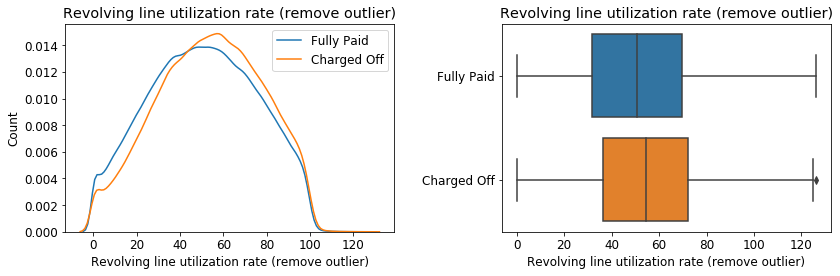

In [212]:
plot_num(df_revol_util, 'revol_util', 'Revolving line utilization rate (remove outlier)', 12,4)

The borrowers who are charged off tend to have higher revolving line utilization rate

**`term`**
- The number of payments on the loan. Values are in months and can be either 36 or 60.

In [103]:
df['term'].describe()

count        1557756
unique             2
top        36 months
freq         1163499
Name: term, dtype: object

In [104]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [105]:
df['term_num'] = df['term'].map({' 36 months':int(36), ' 60 months': int(60)})

In [106]:
df.drop(['term'], axis=1, inplace=True)

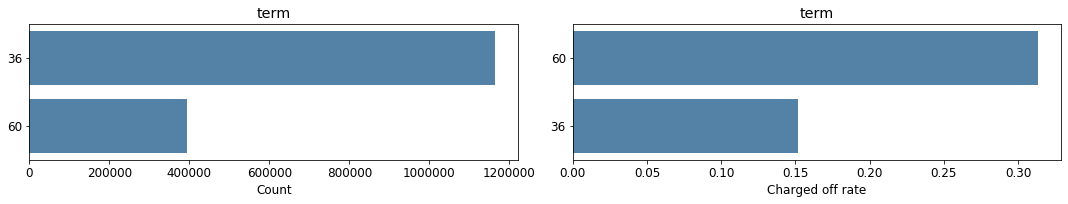

In [116]:
plot_cat(df, 'term_num', 'term', 3)

In [117]:
df['term_num'].value_counts()

36    1163499
60     394257
Name: term_num, dtype: int64

**`grade`**
- LC assigned loan grade

In [118]:
df['grade'].describe()

count     1557756
unique          7
top             B
freq       457923
Name: grade, dtype: object

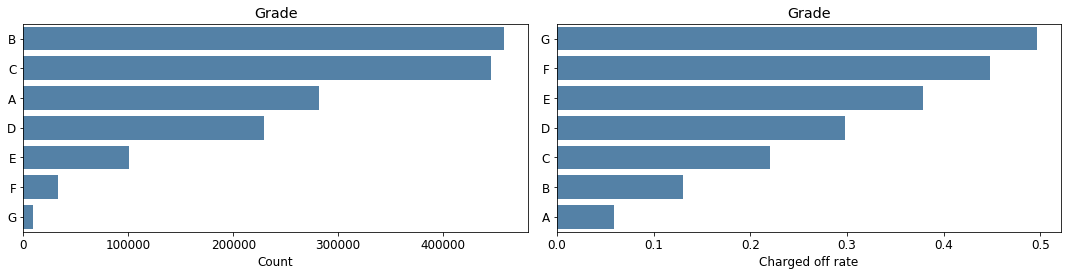

In [119]:
plot_cat(df, 'grade', 'Grade', 4)

In [120]:
df['grade_num'] = df['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [121]:
df['grade_num'].unique()

array([3, 1, 2, 4, 5, 6, 7])

In [ ]:
df.drop(['grade'], axis=1, inplace=True)

**`emp_length`**
- Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

In [122]:
df['emp_length'].describe()

count       1557756
unique           11
top       10+ years
freq         551677
Name: emp_length, dtype: object

In [123]:
def finding_emp_length(emp_length):
    if emp_length == '< 1 year':
        return 0
    elif emp_length == '1 year':
        return 1
    elif emp_length == '2 years':
        return 2
    elif emp_length == '3 years':
        return 3
    elif emp_length == '4 years':
        return 4
    elif emp_length == '5 years':
        return 5
    elif emp_length == '6 years':
        return 6
    elif emp_length == '7 years':
        return 7
    elif emp_length == '8 years':
        return 8
    elif emp_length == '9 years':
        return 9
    elif emp_length == '10+ years':
        return 10

    
df['emp_length_num'] = df['emp_length'].apply(finding_emp_length)

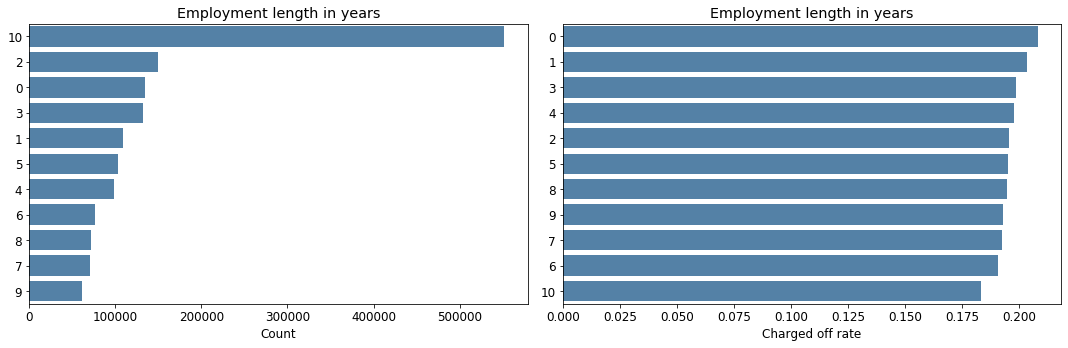

In [124]:
#df.columns#['emp_length'].head()
plot_cat(df, 'emp_length_num', 'Employment length in years',5)

In [125]:
df['emp_length_num'].unique()

array([10,  3,  4,  2,  5,  6,  1,  7,  8,  0,  9])

In [126]:
df.drop(['emp_length'], axis=1, inplace=True)

**`'home_ownership'`**
- The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

In [127]:
df['home_ownership'].describe()

count      1557756
unique           6
top       MORTGAGE
freq        775575
Name: home_ownership, dtype: object

In [128]:
df['home_ownership'].value_counts()

MORTGAGE    775575
RENT        618969
OWN         162341
ANY            785
OTHER           43
NONE            43
Name: home_ownership, dtype: int64

In [129]:
# drop NONE
df = df[df['home_ownership']!='NONE']
df['home_ownership'].value_counts()

MORTGAGE    775575
RENT        618969
OWN         162341
ANY            785
OTHER           43
Name: home_ownership, dtype: int64

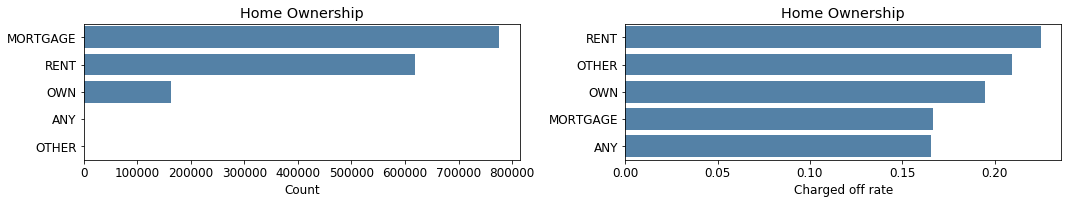

In [130]:
plot_cat(df, 'home_ownership', 'Home Ownership', 3)

**`verification_status`**
- Indicates if income was verified by LC, not verified, or if the income source was verified


In [131]:
df['verification_status'].describe()

count             1557713
unique                  3
top       Source Verified
freq               639160
Name: verification_status, dtype: object

In [132]:
df['verification_status'].unique()

array(['Not Verified', 'Verified', 'Source Verified'], dtype=object)

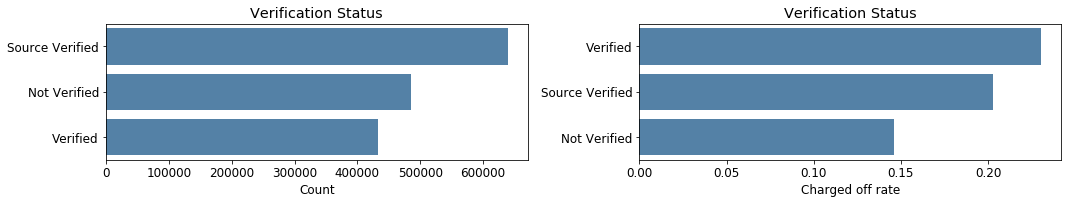

In [133]:
plot_cat(df,'verification_status', 'Verification Status',3)

**`purpose`**
- A category provided by the borrower for the loan request.

In [134]:
df['purpose'].describe()

count                1557713
unique                    14
top       debt_consolidation
freq                  903300
Name: purpose, dtype: object

In [135]:
df['purpose'].unique()

array(['other', 'debt_consolidation', 'home_improvement', 'credit_card',
       'major_purchase', 'small_business', 'house', 'moving', 'medical',
       'car', 'vacation', 'renewable_energy', 'wedding', 'educational'],
      dtype=object)

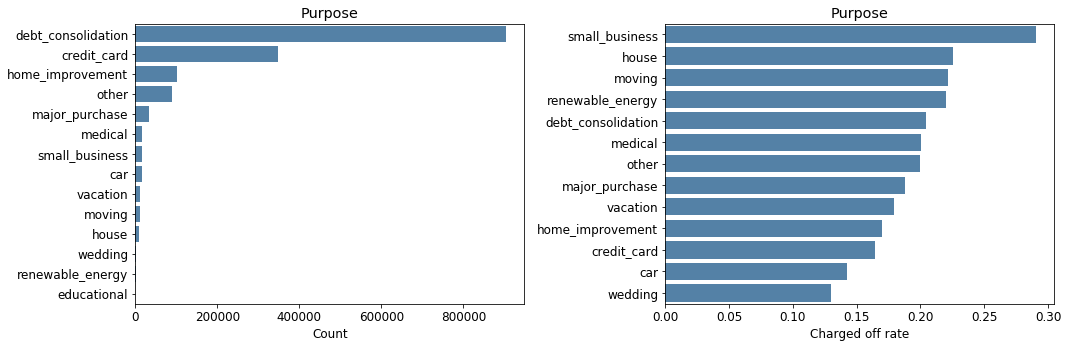

In [136]:
plot_cat(df,'purpose', 'Purpose',5)

**`addr_state`**
- The state provided by the borrower in the loan application

In [137]:
df['addr_state'].describe()

count     1557713
unique         51
top            CA
freq       222858
Name: addr_state, dtype: object

In [138]:
# remove 'IA'
df = df[df['addr_state'] != 'IA']

In [139]:
df['addr_state'].unique()

array(['NY', 'TX', 'MI', 'NC', 'CT', 'FL', 'CA', 'CO', 'NM', 'MA', 'NJ',
       'PA', 'UT', 'SC', 'OH', 'IN', 'AZ', 'DE', 'KY', 'GA', 'WI', 'IL',
       'MO', 'WY', 'TN', 'WA', 'MD', 'VA', 'MN', 'NH', 'NV', 'KS', 'AL',
       'RI', 'OR', 'WV', 'LA', 'VT', 'AR', 'OK', 'HI', 'MT', 'AK', 'SD',
       'DC', 'NE', 'MS', 'ID', 'ME', 'ND'], dtype=object)

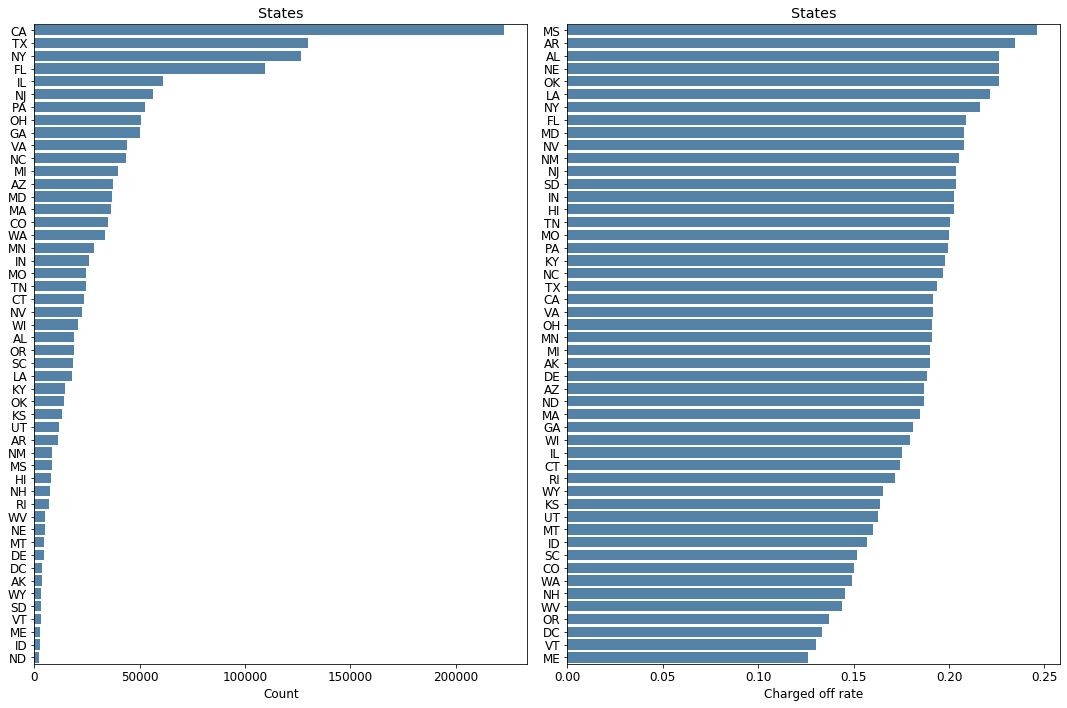

In [140]:
plot_cat(df,'addr_state', 'States',10)

**`loan_amnt`**
- The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value

In [141]:
df['loan_amnt'].describe()

count    1.557711e+06
mean     1.481683e+04
std      8.931093e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.252500e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

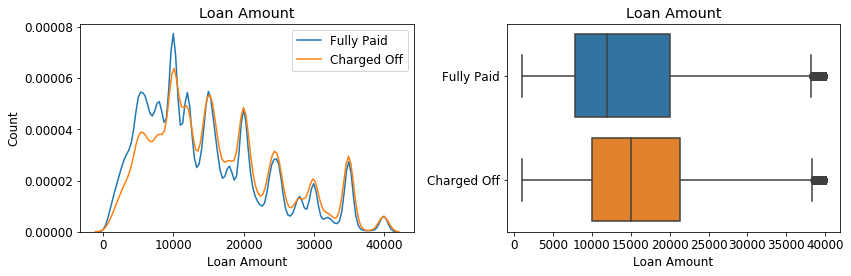

In [213]:
plot_num(df,'loan_amnt', 'Loan Amount',12,4)

remove outlier

In [143]:
df_loan_amnt = df[['loan_amnt', 'loan_status']].copy()
print(len(df_loan_amnt))

1557711


In [144]:
df_loan_amnt = remove_outlier_IQR(df_loan_amnt, 'loan_amnt')
print(len(df_loan_amnt))

1543142


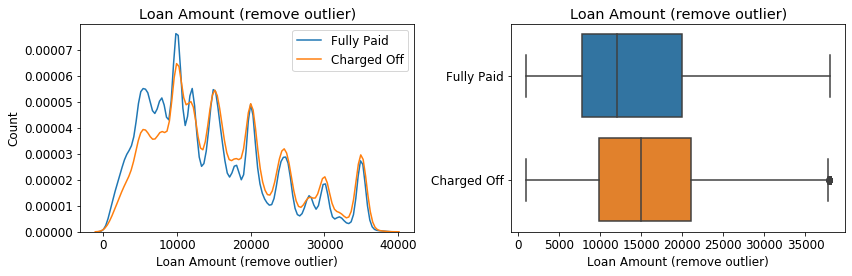

In [214]:
plot_num(df_loan_amnt,'loan_amnt', 'Loan Amount (remove outlier)',12,4)

**`funded_amnt`**
- The total amount committed to that loan at that point in time.

In [146]:
df['funded_amnt'].describe()

count    1.557711e+06
mean     1.481652e+04
std      8.930874e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.252500e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64

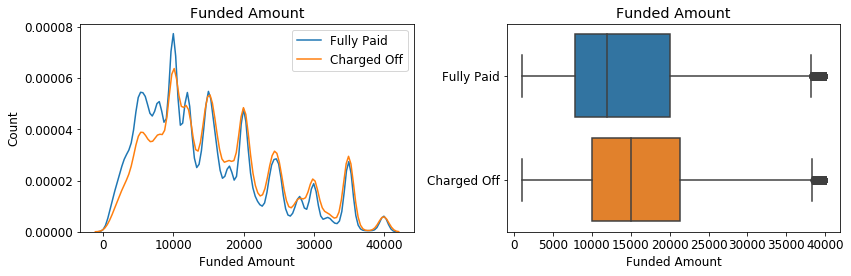

In [215]:
plot_num(df, 'funded_amnt', 'Funded Amount',12,4)

In [148]:
df_funded_amnt = df[['funded_amnt', 'loan_status']].copy()
print(len(df_funded_amnt))

1557711


In [149]:
df_funded_amnt = remove_outlier_IQR(df_funded_amnt, 'funded_amnt')
print(len(df_funded_amnt))

1543142


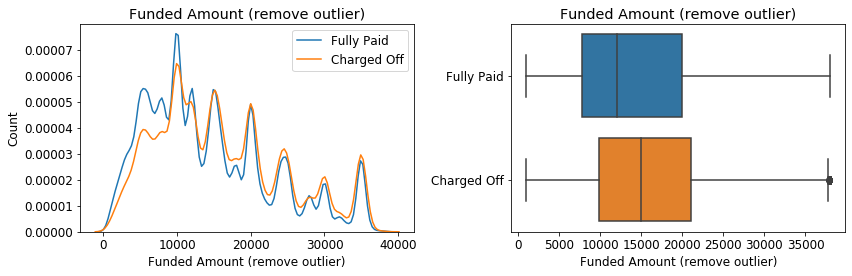

In [216]:
plot_num(df_funded_amnt, 'funded_amnt', 'Funded Amount (remove outlier)',12,4)

**`installment`**
- The monthly payment owed by the borrower if the loan originates.

In [151]:
df['installment'].describe()

count    1.557711e+06
mean     4.476964e+02
std      2.665628e+02
min      4.930000e+00
25%      2.540850e+02
50%      3.817400e+02
75%      5.947800e+02
max      1.719830e+03
Name: installment, dtype: float64

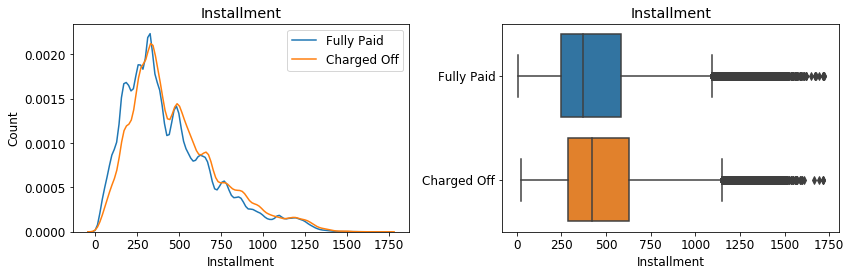

In [217]:
plot_num(df,'installment', 'Installment',12,4)

remove outlier

In [153]:
df_installment = df[['installment', 'loan_status']].copy()
print(len(df_installment))

1557711


In [154]:
df_installment = remove_outlier_IQR(df_installment, 'installment')
print(len(df_installment))

1511938


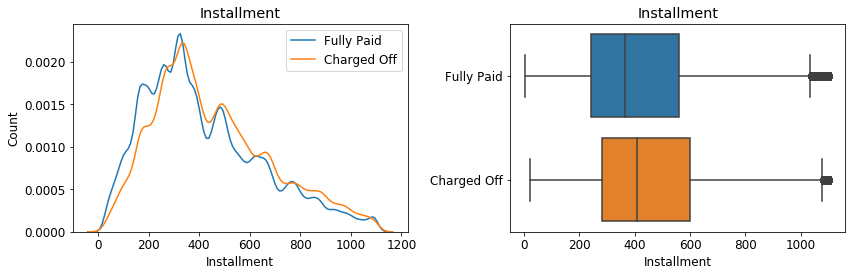

In [218]:
plot_num(df_installment,'installment', 'Installment',12,4)

**`annual_inc`**
- The self-reported annual income provided by the borrower during registration.

In [156]:
df['annual_inc'].describe()

count    1.557711e+06
mean     7.901724e+04
std      1.143187e+05
min      0.000000e+00
25%      4.800000e+04
50%      6.600000e+04
75%      9.500000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

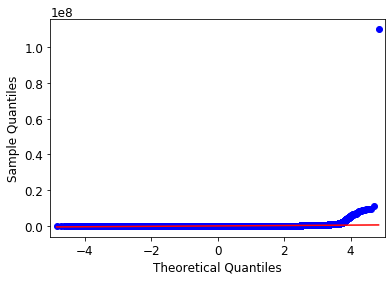

In [157]:
sm.qqplot(df['annual_inc'], line='s')#, line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

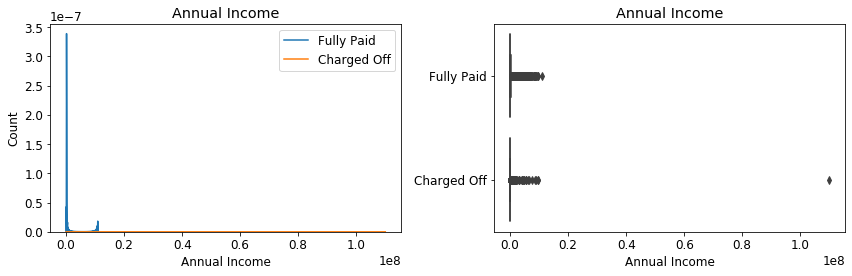

In [219]:
# without log transform
plot_num(df,'annual_inc', 'Annual Income',12,4)

Annual income ranges from 0 to 110,000,000, with a median of 68,000. Because of the large range of annual incomes, we can take a log transform of the annual income variable.

In [159]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x))

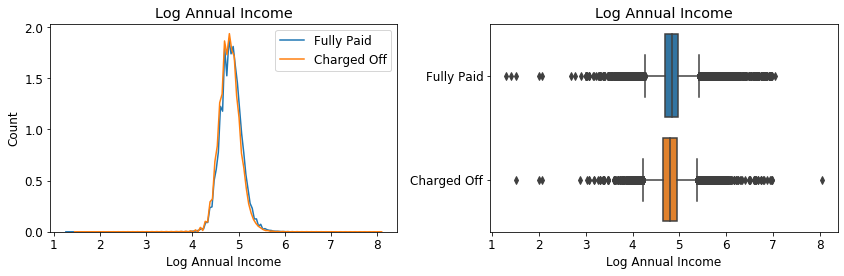

In [220]:
# after log transform
plot_num(df,'log_annual_inc', 'Log Annual Income',12,4)

remove outlier

In [161]:
df_log_annual_inc = df[['log_annual_inc', 'loan_status']].copy()
print(len(df_log_annual_inc))

1557711


In [162]:
df_log_annual_inc = remove_outlier_IQR(df_log_annual_inc, 'log_annual_inc')
print(len(df_log_annual_inc))

1534913


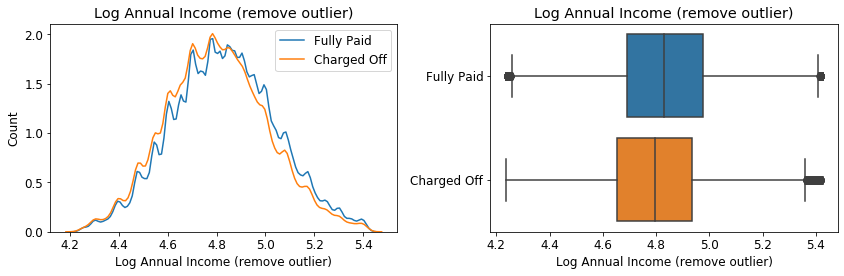

In [221]:
plot_num(df_log_annual_inc ,'log_annual_inc', 'Log Annual Income (remove outlier)',12,4)

**`dti`**
- A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

In [164]:
df['dti'].describe()

count    1.557711e+06
mean     1.843317e+01
std      1.057427e+01
min     -1.000000e+00
25%      1.190000e+01
50%      1.773000e+01
75%      2.424000e+01
max      9.990000e+02
Name: dti, dtype: float64

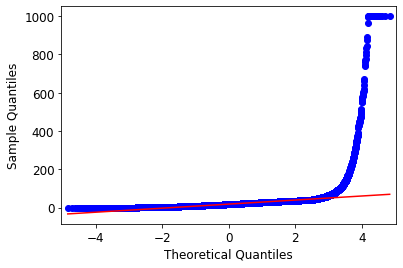

In [165]:
sm.qqplot(df['dti'], line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

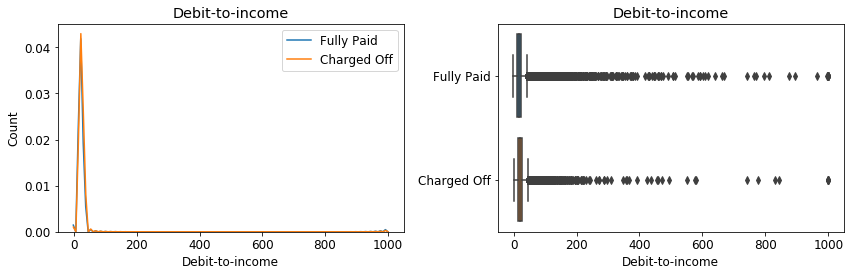

In [222]:
plot_num(df,'dti', 'Debit-to-income',12,4)

In [167]:
df['log_dti'] = df['dti'].apply(lambda x: np.log10(x))

In [168]:
# check missing values
df['log_dti'].isnull().sum()

2

In [169]:
#Drop the row where at least one element is missing.
df['log_dti'].dropna(axis=0, inplace=True)

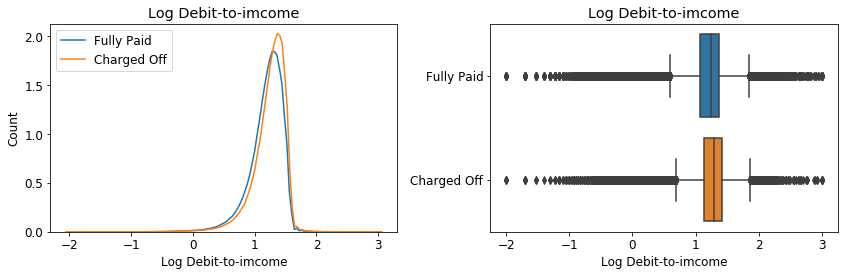

In [223]:
# after log transform
plot_num(df,'log_dti', 'Log Debit-to-imcome',12,4)

remove outlier

1557711
1502853


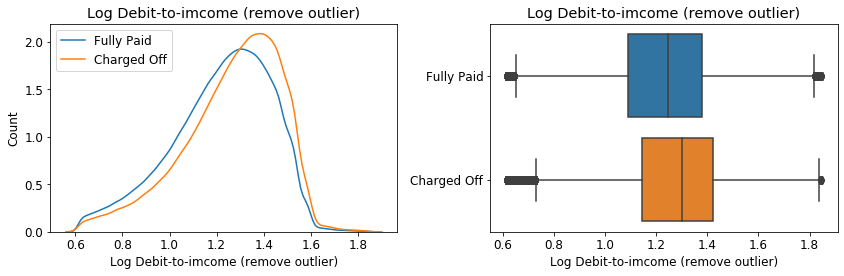

In [224]:
df_log_dti = df[['log_dti', 'loan_status']].copy()
print(len(df_log_dti))

df_log_dti = remove_outlier_IQR(df_log_dti, 'log_dti')
print(len(df_log_dti))

plot_num(df_log_dti ,'log_dti', 'Log Debit-to-imcome (remove outlier)',12,4)

**`revol_bal`**
- Total credit revolving balance

In [172]:
df['revol_bal'].describe()

count    1.557711e+06
mean     1.655974e+04
std      2.274584e+04
min      0.000000e+00
25%      6.045000e+03
50%      1.131600e+04
75%      2.006500e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

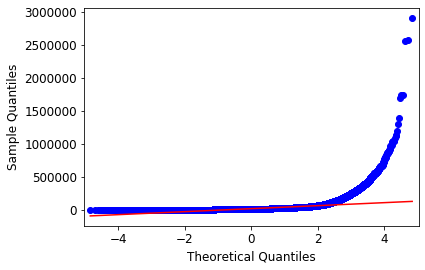

In [173]:
sm.qqplot(df['revol_bal'], line='s')
#plt.ylim(0,0.25e7)
plt.show()

not a normal distribution

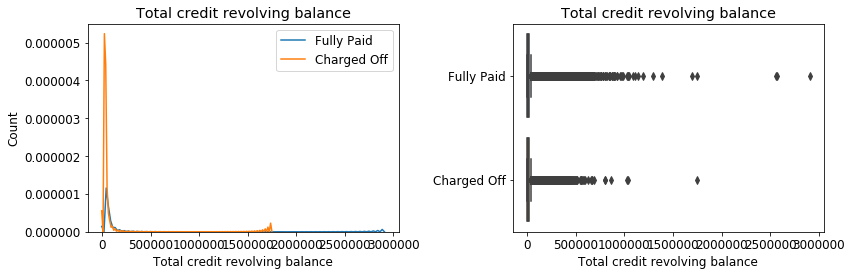

In [225]:
plot_num(df,'revol_bal', 'Total credit revolving balance',12,4)

In [175]:
df['log_revol_bal'] = df['revol_bal'].apply(lambda x: np.log10(x))

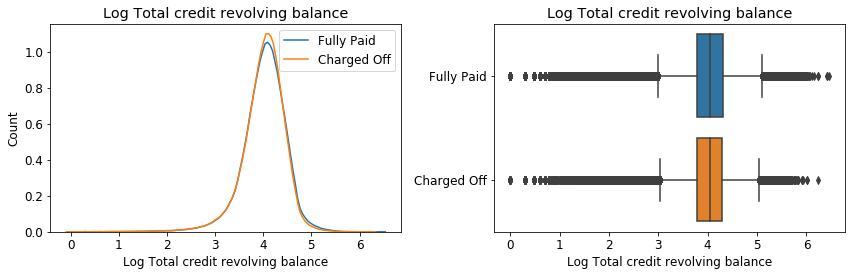

In [226]:
plot_num(df,'log_revol_bal', 'Log Total credit revolving balance',12,4)

remove outlier

1557711
1502096


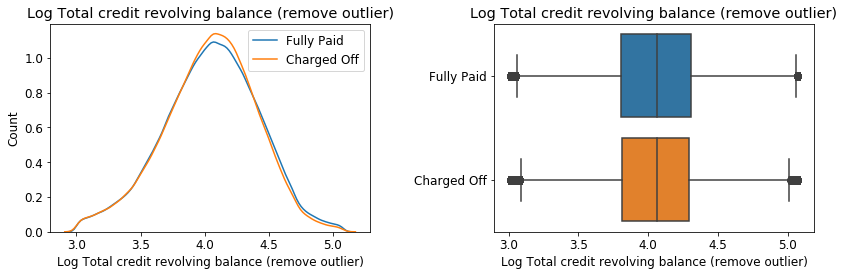

In [227]:
df_log_revol_bal = df[['log_revol_bal', 'loan_status']].copy()
print(len(df_log_revol_bal))

df_log_revol_bal = remove_outlier_IQR(df_log_revol_bal , 'log_revol_bal')
print(len(df_log_revol_bal))

plot_num(df_log_revol_bal ,'log_revol_bal', 'Log Total credit revolving balance (remove outlier)',12,4)

**`delinq_2yrs`**
- The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

In [178]:
df['delinq_2yrs'].describe()

count    1.557711e+06
mean     3.236993e-01
std      8.912135e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: delinq_2yrs, dtype: float64

In [179]:
df['delinq_2yrs'].unique()

array([ 1.,  0.,  2.,  3.,  4.,  6.,  5.,  7.,  8.,  9., 15., 11., 13.,
       10., 12., 17., 18., 29., 24., 14., 21., 22., 19., 16., 30., 26.,
       20., 27., 39., 42., 25., 28., 36., 23.])

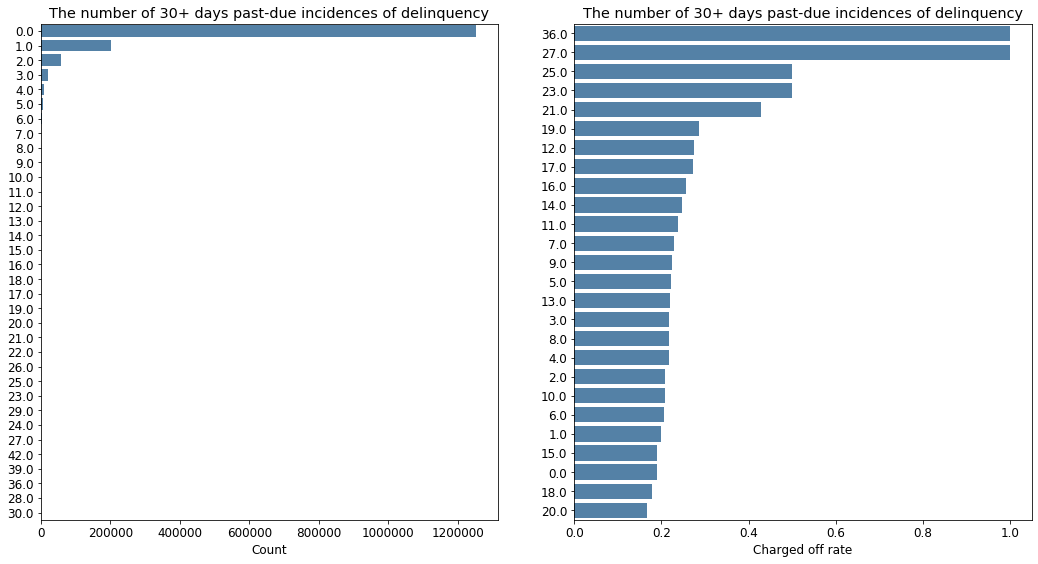

In [180]:
plot_cat(df,'delinq_2yrs', 'The number of 30+ days past-due incidences of delinquency',8)

(0, 1000)

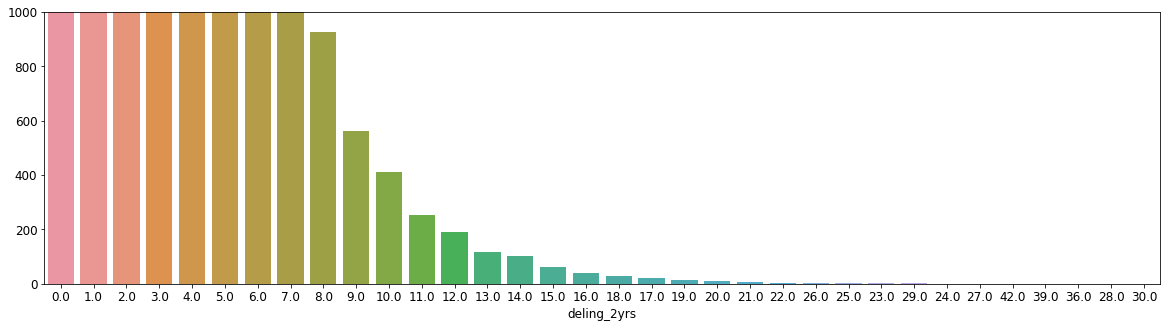

In [181]:
plt.figure(figsize=(20,5))
sns.countplot(x='delinq_2yrs', data = df,\
              order = df['delinq_2yrs'].value_counts().index)
plt.xlabel('deling_2yrs')
plt.ylabel('Count')
plt.ylabel('')
plt.ylim(0,1000)
#ax1.set_title(full_name)

In [182]:
df['log_delinq_2yrs'] = df['delinq_2yrs'].apply(lambda x: np.log10(x))

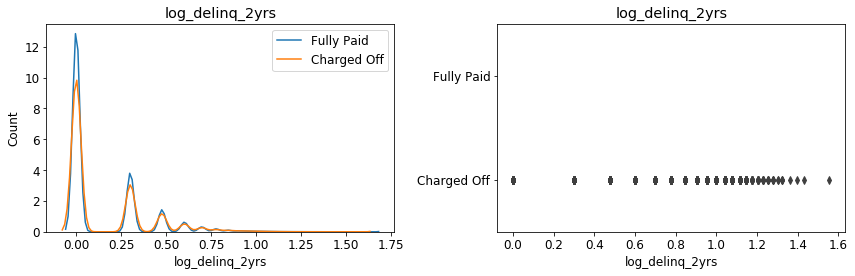

In [228]:
plot_num(df,'log_delinq_2yrs', 'log_delinq_2yrs',12,4)

1557711
1557711


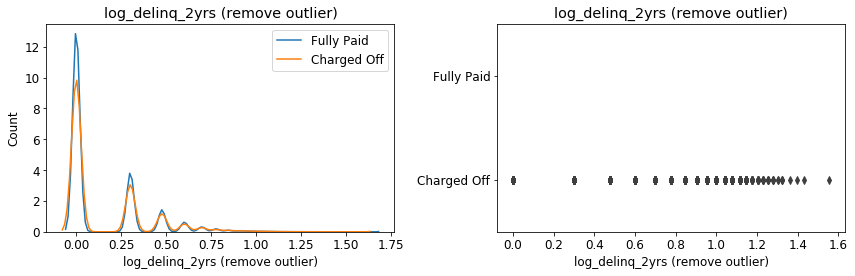

In [229]:
df_log_delinq_2yrs = df[['log_delinq_2yrs', 'loan_status']].copy()
print(len(df_log_delinq_2yrs))

df_log_delinq_2yrs = remove_outlier_IQR(df_log_delinq_2yrs , 'log_delinq_2yrs')
print(len(df_log_delinq_2yrs))

plot_num(df_log_delinq_2yrs ,'log_delinq_2yrs', 'log_delinq_2yrs (remove outlier)',12,4)

**`open_acc`**
- The number of open credit lines in the borrower's credit file.

In [185]:
df['open_acc'].describe()

count    1.557711e+06
mean     1.175628e+01
std      5.576078e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

In [186]:
df['open_acc'].unique()

array([ 9., 17., 14., 15.,  3., 12.,  6.,  8.,  4., 10.,  7., 16., 29.,
        5., 11., 13., 20., 21., 19., 30., 27., 18., 25., 23., 22., 24.,
       40., 26.,  2., 28., 31.,  1., 37., 32., 33., 42., 41., 34., 39.,
       36., 35., 45., 49., 38., 53., 51., 43., 62., 44., 46., 48., 50.,
       52., 54., 47., 76., 58., 55., 84., 75., 61., 65., 67., 57., 66.,
       68., 70., 60., 56., 82., 63., 59., 64., 79., 74., 90., 72., 77.,
       81., 71., 69., 80., 86., 88.])

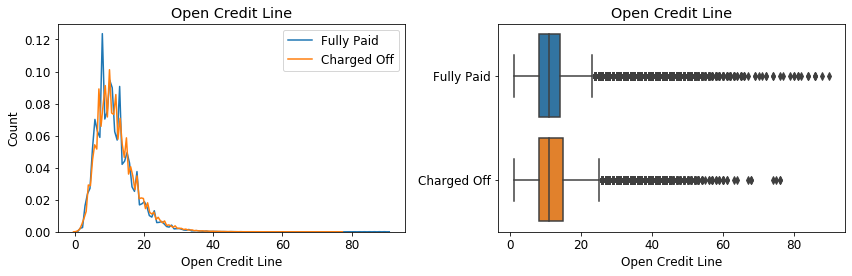

In [230]:
plot_num(df,'open_acc', 'Open Credit Line',12,4)

remove outlier

1557711
1520447


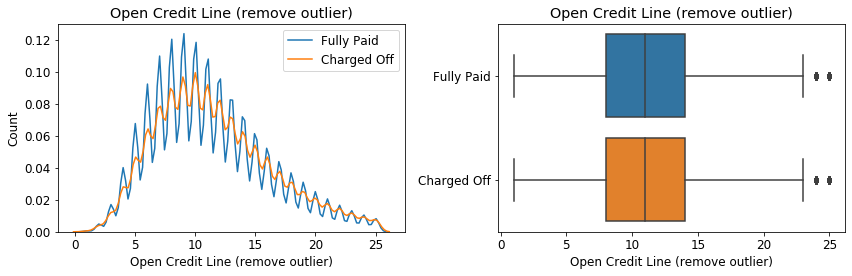

In [231]:
df_open_acc = df[['open_acc', 'loan_status']].copy()
print(len(df_open_acc))

df_open_acc = remove_outlier_IQR(df_open_acc , 'open_acc')
print(len(df_open_acc))

plot_num(df_open_acc ,'open_acc', 'Open Credit Line (remove outlier)',12,4)

**`pub_rec`**
- Number of derogatory public records

In [189]:
df['pub_rec'].describe()

count    1.557711e+06
mean     2.097083e-01
std      5.993250e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

In [190]:
df['pub_rec'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  9.,  8.,  7., 11., 49., 10.,
       54., 12., 18., 19., 16., 15., 14., 40., 63., 13., 21., 34., 17.,
       23., 28., 20., 86., 22., 46., 37., 31., 47., 24., 45., 25., 61.,
       32., 44., 52.])

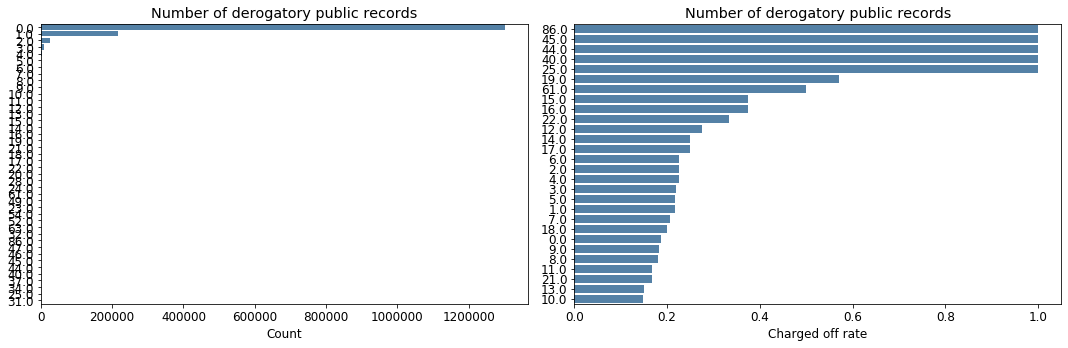

In [191]:
plot_cat(df,'pub_rec', 'Number of derogatory public records')

**`fico_range_high`**

**`fico_range_low`**

In [192]:
df['fico'] = (df['fico_range_high']  + df['fico_range_high'])/2

In [193]:
df['fico'].describe()

count    1.557711e+06
mean     7.005728e+02
std      3.193881e+01
min      6.640000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: fico, dtype: float64

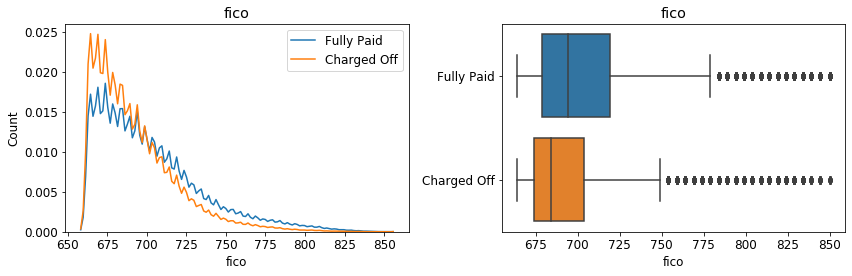

In [232]:
plot_num(df,'fico', 'fico',12,4)

remove outlier

1557711
1503323


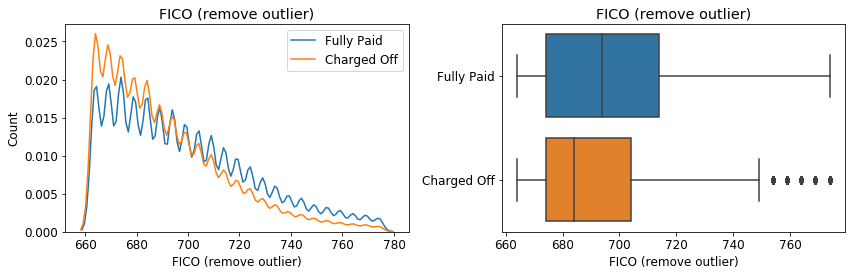

In [233]:
df_fico = df[['fico', 'loan_status']].copy()
print(len(df_fico))

df_fico = remove_outlier_IQR(df_fico , 'fico')
print(len(df_fico))

plot_num(df_fico ,'fico', 'FICO (remove outlier)',12,4)

**`total_pymnt`**

In [196]:
df['total_pymnt'].describe()

count    1.557711e+06
mean     1.542235e+04
std      1.065404e+04
min      1.000000e+01
25%      7.157923e+03
50%      1.263496e+04
75%      2.141534e+04
max      6.450823e+04
Name: total_pymnt, dtype: float64

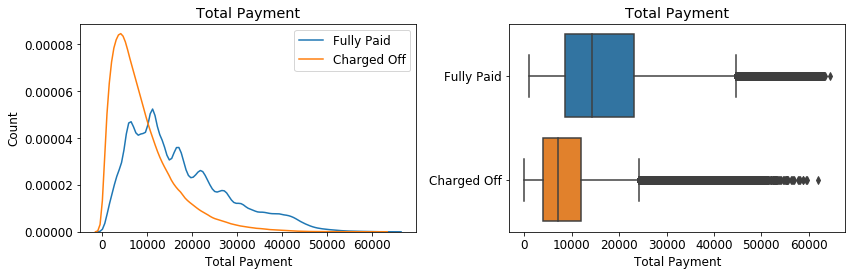

In [234]:
plot_num(df,'total_pymnt', 'Total Payment',12,4)

remove outlier

1557711
1526818


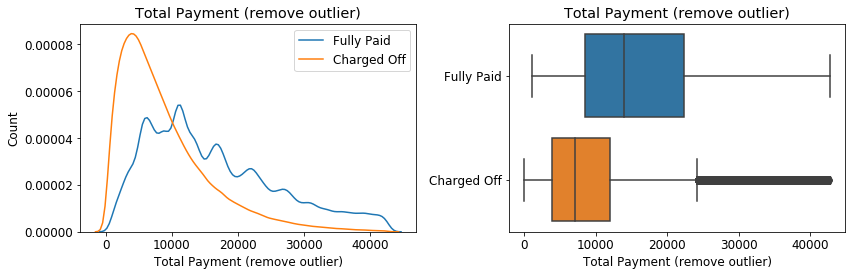

In [235]:
df_total_pymnt = df[['total_pymnt', 'loan_status']].copy()
print(len(df_total_pymnt))

df_total_pymnt = remove_outlier_IQR(df_total_pymnt , 'total_pymnt')
print(len(df_total_pymnt))

plot_num(df_total_pymnt ,'total_pymnt', 'Total Payment (remove outlier)',12,4)

**`recoveries`**
- post charge off gross recovery

In [199]:
df['recoveries'].describe()

count    1.557711e+06
mean     2.655562e+02
std      1.033658e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.985955e+04
Name: recoveries, dtype: float64

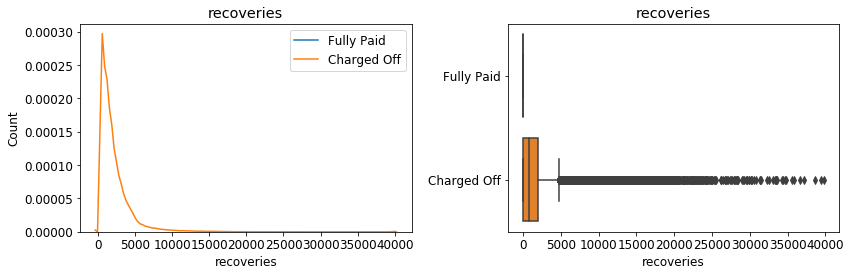

In [236]:
plot_num(df,'recoveries', 'recoveries',12,4)

remove outlier

300218
285820


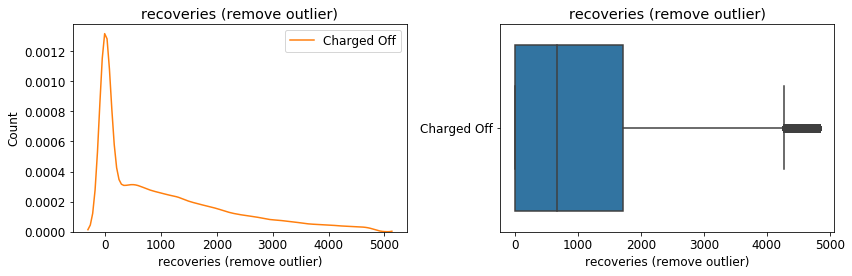

In [245]:
df_recoveries = df[df['loan_status']=='Charged Off'][['recoveries', 'loan_status']].copy()
#df_recoveries = df[['recoveries', 'loan_status']].copy()
print(len(df_recoveries))

df_recoveries = remove_outlier_IQR(df_recoveries , 'recoveries')
print(len(df_recoveries))

plot_num(df_recoveries ,'recoveries', 'recoveries (remove outlier)',12,4)

borrowers who paid off on time does not have recoveries feature. Remove this feature for ML

**`return_3`**
"

In [202]:
df['return_3'].describe()

count    1.557711e+06
mean     5.439033e-02
std      1.026333e-01
min     -3.330833e-01
25%      4.225872e-02
50%      7.404530e-02
75%      1.099745e-01
max      1.675665e+00
Name: return_3, dtype: float64

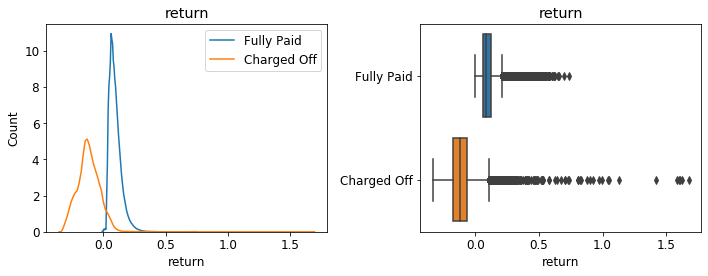

In [313]:
plot_num(df,'return_3', 'return',10,4)

In [326]:
df['log_return_1'] = df['return_1'].apply(lambda x: np.log10(x) if x>0 else np.log10(-x))
df['log_return_3'] = df['return_3'].apply(lambda x: np.log10(x) if x>0 else np.log10(-x))

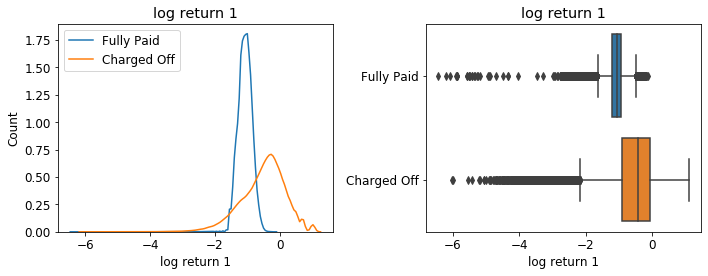

In [327]:
plot_num(df,'log_return_1', 'log return 1',10,4)

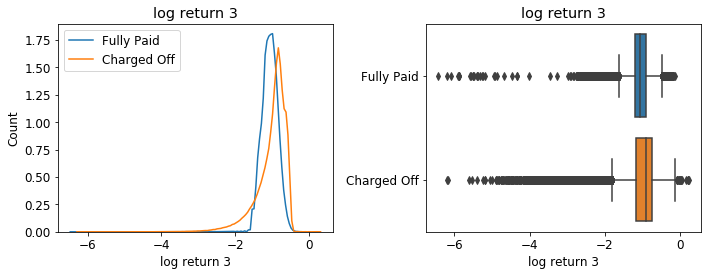

In [328]:
plot_num(df,'log_return_3', 'log return 3',10,4)

return_1 uses "loan period" to calcualte the return. The loss is over-weight. Therefore, it is better to use return_2 to calculate the loss. However, after remove the outlier, they look similar.

### Summary

In [330]:
df.to_csv('LC_preprocessing.csv') # after cleanup (but not remove outlier)

prepare ML data

In [349]:
# pick up columns for ML
col_cal = ['home_ownership', 'verification_status', 'purpose', 'addr_state','pub_rec']
col_num = ['term_num','grade_num','loan_period','int_rate', 'revol_util','loan_amnt', 'funded_amnt', 'installment','open_acc','fico','total_pymnt',\
          'log_annual_inc', 'log_dti','log_revol_bal', 'log_delinq_2yrs', 'emp_length_num', 'log_return_3']
col_date = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']
col_target = ['target']

In [350]:
col_set = col_cal + col_num + col_date + col_target
print(col_set)

['home_ownership', 'verification_status', 'purpose', 'addr_state', 'pub_rec', 'term_num', 'grade_num', 'loan_period', 'int_rate', 'revol_util', 'loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'fico', 'total_pymnt', 'log_annual_inc', 'log_dti', 'log_revol_bal', 'log_delinq_2yrs', 'emp_length_num', 'log_return_3', 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'target']


In [351]:
print(len(col_set))

26


In [352]:
df_ML = df[col_set].copy()

In [353]:
# remove missing values in row
df_ML.dropna(axis=0, inplace=True)

In [354]:
df_ML.reset_index(drop=True, inplace=True)
df_ML.head()

,home_ownership,verification_status,purpose,addr_state,pub_rec,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,log_return_3,issue_d,earliest_cr_line,last_pymnt_d,target
0,MORTGAGE,Not Verified,other,NY,0.0,36,3,26.021068,14.98,66.2,11100.0,11100.0,384.68,9.0,694.0,13575.640006,4.954243,0.571709,3.820792,0.0,10,-0.987779,2013-12-01,2001-06-01,2016-02-01,0
1,MORTGAGE,Not Verified,debt_consolidation,TX,0.0,36,1,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3,-1.331706,2013-12-01,2003-09-01,2016-06-01,0
2,OWN,Verified,debt_consolidation,MI,0.0,36,2,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10,-1.171766,2013-12-01,1986-10-01,2016-07-01,0
3,RENT,Not Verified,debt_consolidation,NC,0.0,36,2,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4,-1.148490,2013-12-01,2009-12-01,2016-04-01,0
4,MORTGAGE,Source Verified,home_improvement,TX,0.0,36,2,9.002238,10.99,16.1,4800.0,4800.0,157.13,3.0,759.0,5157.519457,4.597695,0.396199,3.616581,-inf,2,-1.003111,2013-12-01,1995-08-01,2014-09-01,0


In [355]:
df_ML.shape

(1557709, 26)

In [356]:
df_ML[col_num].isnull().sum()

term_num           0
grade_num          0
loan_period        0
int_rate           0
revol_util         0
loan_amnt          0
funded_amnt        0
installment        0
open_acc           0
fico               0
total_pymnt        0
log_annual_inc     0
log_dti            0
log_revol_bal      0
log_delinq_2yrs    0
emp_length_num     0
log_return_3       0
dtype: int64

In [357]:
df_ML[col_num].head()

,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,log_return_3
0,36,3,26.021068,14.98,66.2,11100.0,11100.0,384.68,9.0,694.0,13575.640006,4.954243,0.571709,3.820792,0.0,10,-0.987779
1,36,1,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3,-1.331706
2,36,2,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10,-1.171766
3,36,2,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4,-1.148490
4,36,2,9.002238,10.99,16.1,4800.0,4800.0,157.13,3.0,759.0,5157.519457,4.597695,0.396199,3.616581,-inf,2,-1.003111


In [358]:
for i in col_num:
    print(i)

term_num
grade_num
loan_period
int_rate
revol_util
loan_amnt
funded_amnt
installment
open_acc
fico
total_pymnt
log_annual_inc
log_dti
log_revol_bal
log_delinq_2yrs
emp_length_num
log_return_3


In [359]:
df_ML_LP = remove_outlier_IQR(df_ML, 'loan_period')
df_ML_LP.shape

(1557709, 26)

remove outlier

In [360]:
df_ML_rm = df_ML.copy()

In [361]:
for feature in col_num:
    df_ML_rm = remove_outlier_IQR(df_ML_rm, feature)

In [362]:
df_ML_rm.shape

(1132216, 26)

In [363]:
df_ML.shape

(1557709, 26)

In [364]:
df_ML_rm[col_num + col_target].head()

,term_num,grade_num,loan_period,int_rate,revol_util,loan_amnt,funded_amnt,installment,open_acc,fico,total_pymnt,log_annual_inc,log_dti,log_revol_bal,log_delinq_2yrs,emp_length_num,log_return_3,target
1,36,1,29.996509,7.62,55.7,12000.0,12000.0,373.94,17.0,709.0,13397.539998,4.984527,1.100715,4.122150,-inf,3,-1.331706,0
2,36,2,30.982156,10.99,61.2,27050.0,27050.0,885.46,14.0,734.0,31752.530000,4.740363,1.359266,4.563932,-inf,10,-1.171766,0
3,36,2,27.992361,10.99,24.0,12000.0,12000.0,392.81,15.0,724.0,13988.609996,4.778151,0.664642,3.853516,-inf,4,-1.148490,0
5,36,1,37.027454,6.62,21.6,12000.0,12000.0,368.45,12.0,764.0,13263.954639,5.021189,1.147676,4.119520,-inf,10,-1.466792,0
6,36,2,37.027454,12.85,81.9,14000.0,14000.0,470.71,6.0,674.0,16945.318783,4.944483,1.000868,3.566555,0.0,4,-1.166338,0


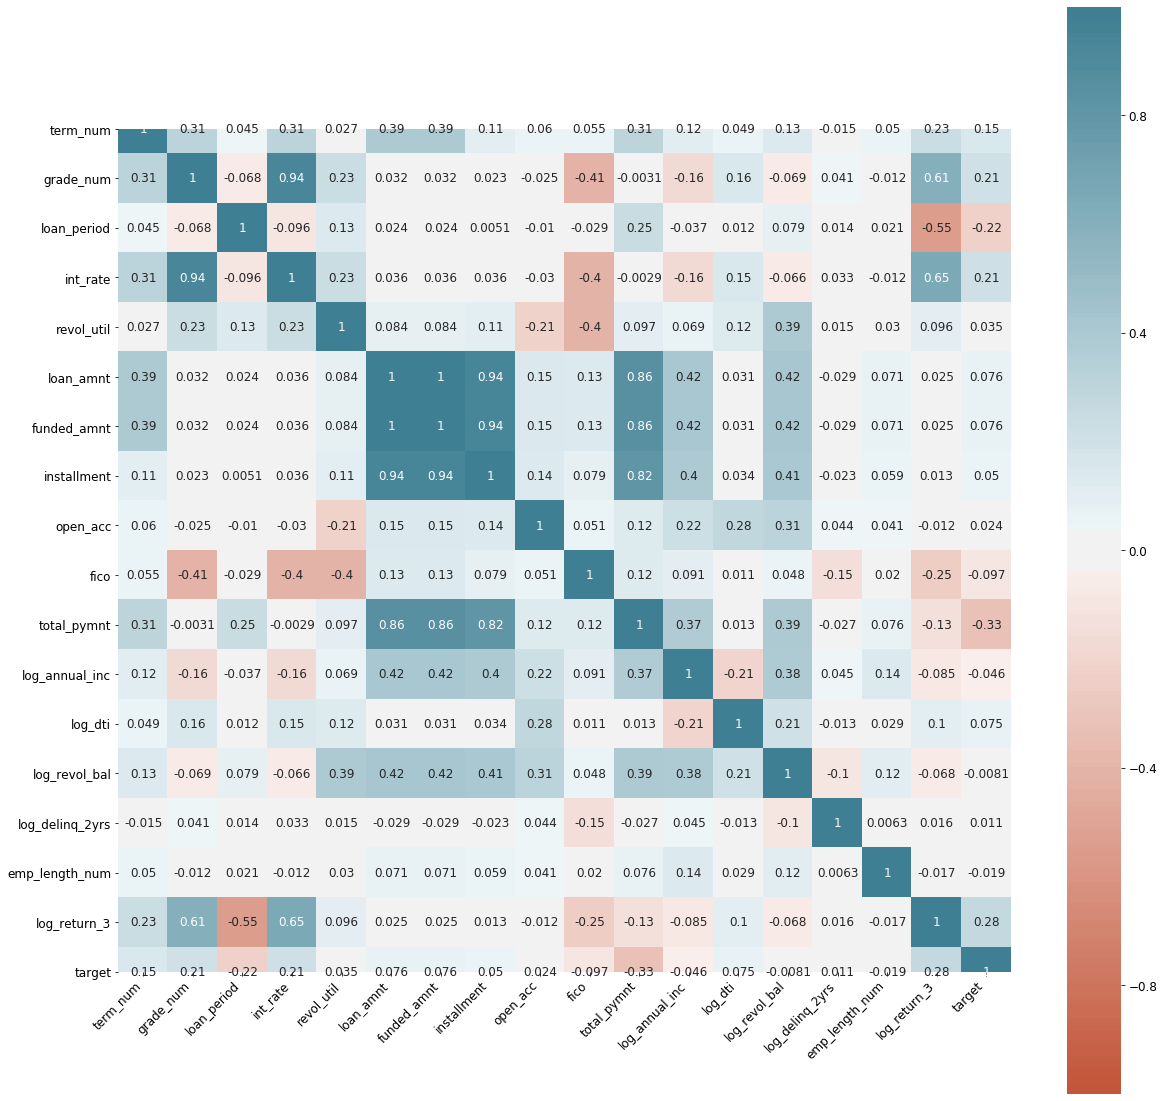

In [365]:
# heatmap

#sns.heatmap(df_ML[col_num].corr(), annot = True,  cbar=True)
#
plt.figure(figsize=(20,20))

ax = sns.heatmap(
    df_ML_rm[col_num+col_target].corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [366]:
df_ML_rm.to_csv('LC_ML_prep.csv')